# Imports

In [8]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import shap
from src.config import CONFIG
from src.data_processing import DataProcessor
import matplotlib.pyplot as plt

# Load and process data

In [9]:
dp = DataProcessor()
data = dp.process_data(CONFIG.DATA_PATH)

cat_cols = dp.CAT_COLS.copy()
num_cols = dp.NUM_COLS.copy()

# Model development

### Train/Test split

Como hay solo 10_000 samples, dejo 1500 para test

In [10]:
X = data.drop(columns=[CONFIG.TARGET])
y = data[CONFIG.TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=CONFIG.SEED, stratify=y)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (8500, 18), Test size: (1500, 18)


### K-Fold Cross-Validation

In [11]:
# pipeline model for scaling and encoding

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Create column transformer for preprocessing
preprocessor = make_column_transformer(
    (StandardScaler(), num_cols),
    (OneHotEncoder(drop='first'), cat_cols)
)

# Build pipeline
pipeline = make_pipeline(
    preprocessor, 
    LogisticRegression(random_state=CONFIG.SEED, max_iter=1000)
    )

In [12]:
from sklearn.model_selection import cross_validate

scoring = {'accuracy': 'accuracy', 'roc_auc': 'roc_auc'}

cv_results = cross_validate(pipeline, X_train, y_train, 
                            cv=CONFIG.N_FOLDS, 
                            scoring=scoring, 
                            return_train_score=True)

print("Cross-validation results:\n")
print(f"  Train Accuracy: {np.mean(cv_results['train_accuracy']):.4f}")
print(f"  Train ROC AUC: {np.mean(cv_results['train_roc_auc']):.4f}")
print(f"  Cross-validation Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"  Cross-validation AUC: {np.mean(cv_results['test_roc_auc']):.4f}")

Cross-validation results:

  Train Accuracy: 0.8955
  Train ROC AUC: 0.9568
  Cross-validation Accuracy: 0.8935
  Cross-validation AUC: 0.9558



Test Accuracy: 0.9040
Test AUC: 0.9623


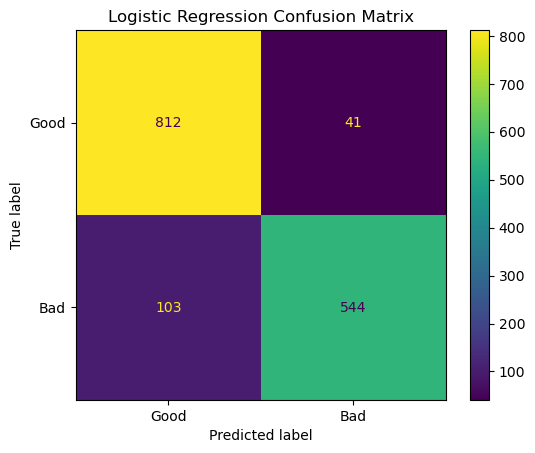

In [13]:
pipeline.fit(X_train, y_train)

y_test_pred = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Good', 'Bad']);
plt.title('Logistic Regression Confusion Matrix')
plt.savefig(os.path.join(CONFIG.RESULTS_DIR, 'lr_confusion_matrix.png'), dpi=120)

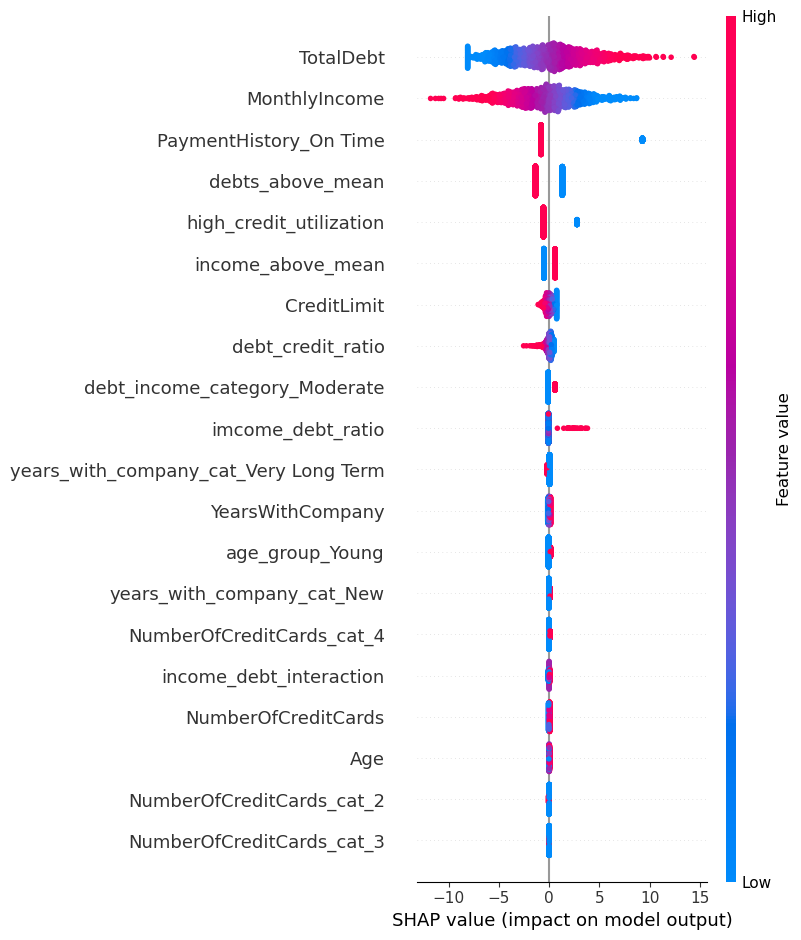

In [14]:
log_reg_model = pipeline.named_steps['logisticregression']

X_train_ = preprocessor.fit_transform(X_train)
X_test_ = preprocessor.transform(X_test)

explainer = shap.Explainer(log_reg_model, X_train_)
shap_values = explainer(X_test_)

# Get feature names for the categorical columns after one-hot encoding
cat_features = preprocessor.transformers_[1][1].get_feature_names_out(cat_cols)

# Combine numerical and categorical feature names
feature_names = np.hstack([num_cols, cat_features])

# Pass the correct feature names to SHAP's summary plot
shap.summary_plot(shap_values, X_test_, feature_names=feature_names, show=False)
plt.savefig(os.path.join(CONFIG.RESULTS_DIR, 'lr_shap_summary.png'), dpi=120)